In [1]:
import sys
sys.dont_write_bytecode = True

from pathlib import Path

import numpy as np
import pandas as pd
import geopandas

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as cx


# Local imports.
from resale_flat_prices.resale_flat_data.resale_flat_data import ResaleFlatData
from resale_flat_prices.resale_flat_data.rent_prices_data import RentPricesData
from resale_flat_prices.h3_utils.h3_statistics import monthly_median_price
from resale_flat_prices.vis_utils.vis_utils import plot_df

# Data directories.
csv_data_dir = Path("../data/ResaleFlatPrices/")
processed_data_dir = Path("../data/processed_data/")

# Load processed and geocoded resale flat data.
resale_flat_data_csv_file = "resale-flat-prices.csv.zip"
rent_prices_data_csv_file = "rent-prices.csv.zip"

In [ ]:
# Calculate the median prices.
price_column = "price_per_sqft"

# Resale flat data.
resale_flat_data = ResaleFlatData(processed_data_dir / resale_flat_data_csv_file)
resale_flat_data.read_csv()
resale_flat_data.df = resale_flat_data.df.sort_values(["year_month", "town"])

# Create additional datetime columns indicating the quarter the resale occured in.
resale_flat_data.df["quarter"] = resale_flat_data.df["month"].apply(lambda x: int(np.ceil(x / 3)))

# Conditions to restrict the data.
resale_flat_data.df = resale_flat_data.df[resale_flat_data.df["year"] >= 2021]
resale_flat_data.df = resale_flat_data.df[resale_flat_data.df["town"] == "ANG MO KIO"]

#resale_flat_data.df = resale_flat_data.df[resale_flat_data.df["street_name_cleaned"] == "ANG MO KIO AVENUE 2"]

resale_flat_data.make_point_geometries(crs = "EPSG:4326")
print("resale_flat_data.df.shape: {}.".format(resale_flat_data.df.shape))

In [19]:
unique_street_names = resale_flat_data.df["street_name_cleaned"].unique()

large = "year"
small = "month"
combined = "datetime"

years = [2021] * 12 + [2022] * 12 + [2023] * 12 + [2024] * 12
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] * 4

datetime_df = pd.DataFrame({large: years, small: months})
datetime_df[combined] = datetime_df[["year", "month"]].apply(
    lambda DF: np.datetime64("{}-{:02d}".format(DF["year"], DF["month"]), "M"), axis=1)
datetime_df["X"] = np.arange(1, len(datetime_df) + 1, 1) / len(datetime_df)

dfs = {}
for s in unique_street_names:
    dfs[s] = resale_flat_data.df[resale_flat_data.df["street_name_cleaned"] == s]
    dfs[s] = dfs[s][[large, small, "price_per_sqft"]].groupby([large, small]).median().reset_index()
    dfs[s] = pd.merge(datetime_df, dfs[s], left_on = [large, small], right_on = [large, small], how = "left")
    dfs[s][combined] = dfs[s][["year", "month"]].apply(
        lambda DF: np.datetime64("{}-{:02d}".format(DF["year"], DF["month"]), "M"), axis=1)
    dfs[s] = dfs[s].dropna()

print(np.array([k for k in dfs.keys()]))

['ANG MO KIO AVENUE 4' 'ANG MO KIO AVENUE 1' 'ANG MO KIO AVENUE 10'
 'ANG MO KIO AVENUE 3' 'ANG MO KIO AVENUE 5' 'ANG MO KIO AVENUE 8'
 'ANG MO KIO AVENUE 9' 'ANG MO KIO AVENUE 6' 'ANG MO KIO STREET 61'
 'ANG MO KIO STREET 31' 'ANG MO KIO STREET 52' 'ANG MO KIO STREET 32'
 'ANG MO KIO STREET 21' 'ANG MO KIO STREET 11' 'ANG MO KIO AVENUE 2'
 'ANG MO KIO STREET 44' 'ANG MO KIO STREET 51']


In [46]:
X_pred_months = datetime_df[combined].values.astype("datetime64[M]")
X_pred = datetime_df["X"].values
X_pred = X_pred.reshape(-1, 1)

# Tack on additional months at the end?
future_months = 6
for i in range(future_months):
    X_pred_months = np.hstack([X_pred_months, X_pred_months[-1] + 1])
    X_pred = np.vstack([X_pred, X_pred[-1] + (X_pred[-1] - X_pred[-2])])

models = {}
y_preds = {}
y_stds = {}
for k in dfs.keys():
    y = dfs[k]["price_per_sqft"].values
    X = dfs[k]["X"].values
    X = X.reshape(-1, 1)
    
    kernel = RBF(12, length_scale_bounds="fixed")
    models[k] = GaussianProcessRegressor(kernel=kernel)

    models[k].fit(X, y)
    y_preds[k] = models[k].predict(X_pred)

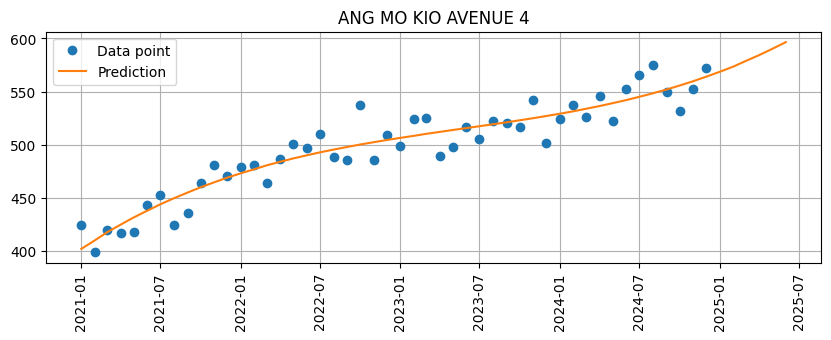

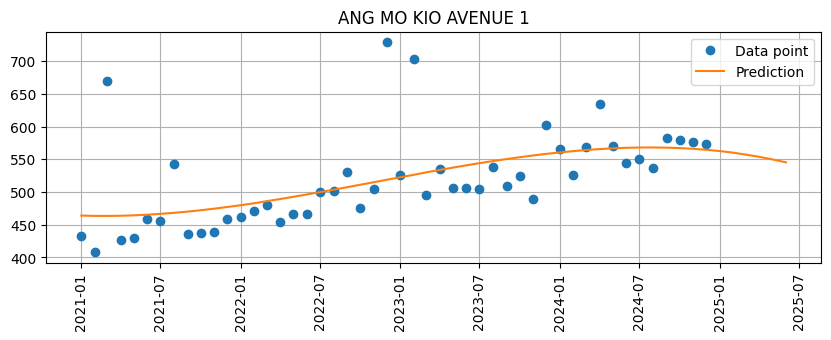

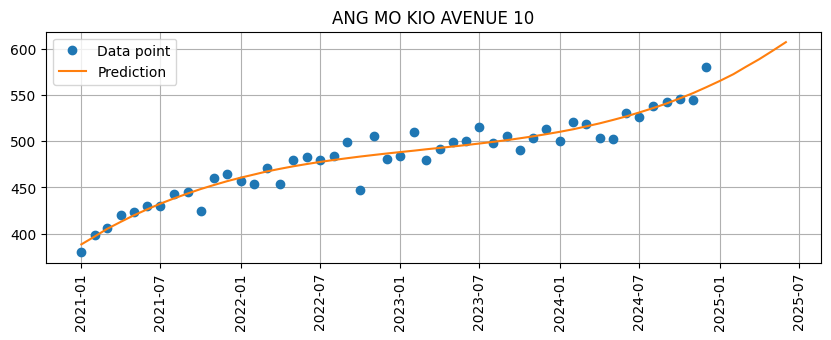

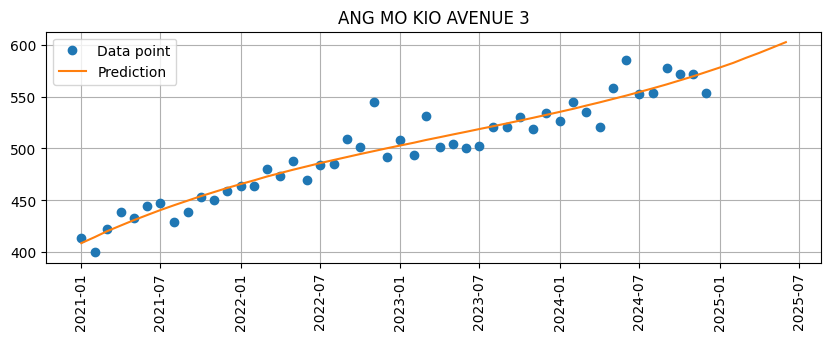

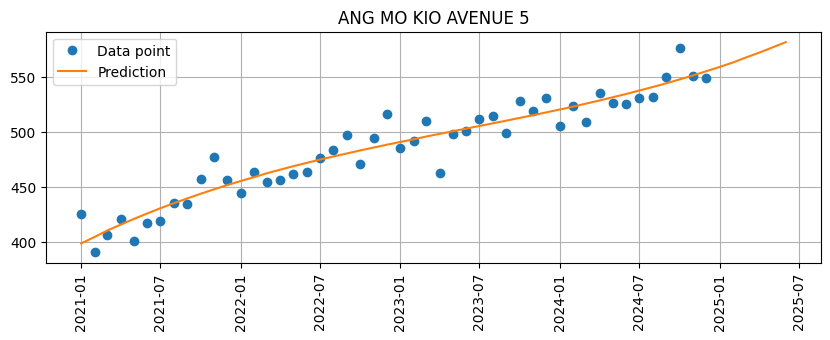

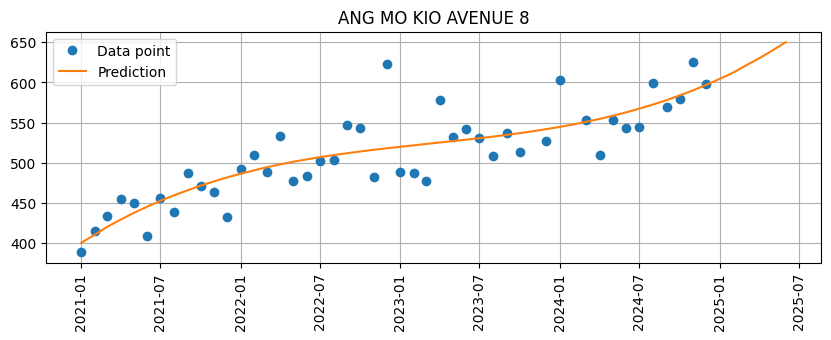

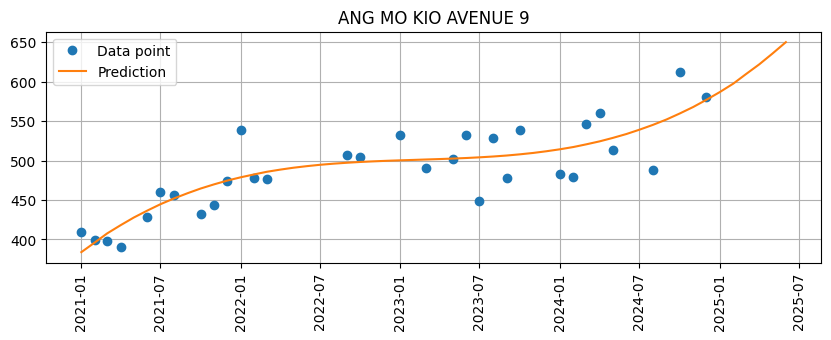

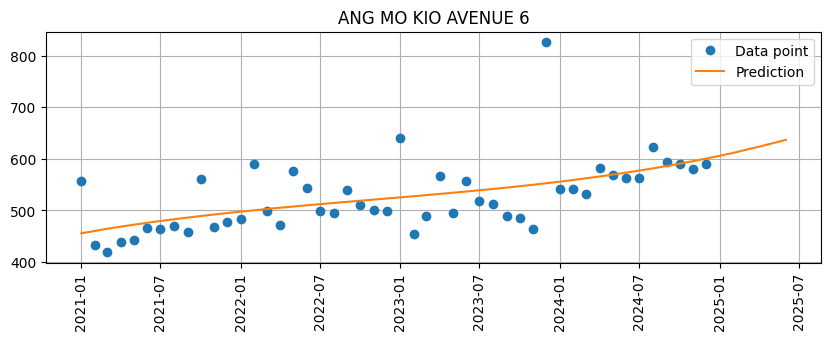

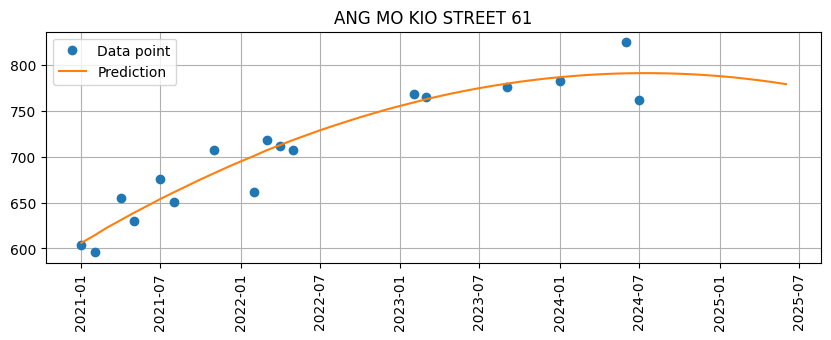

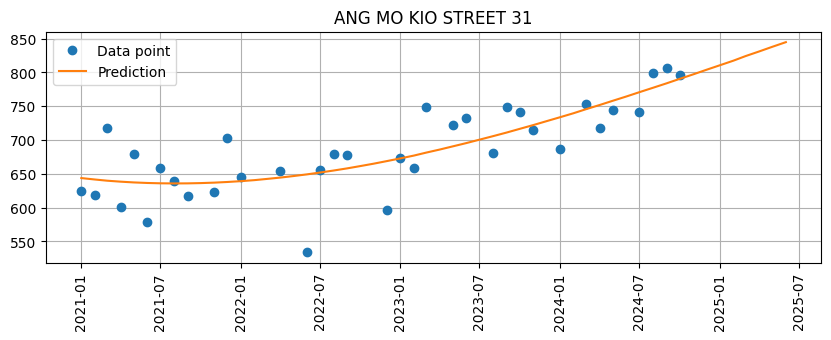

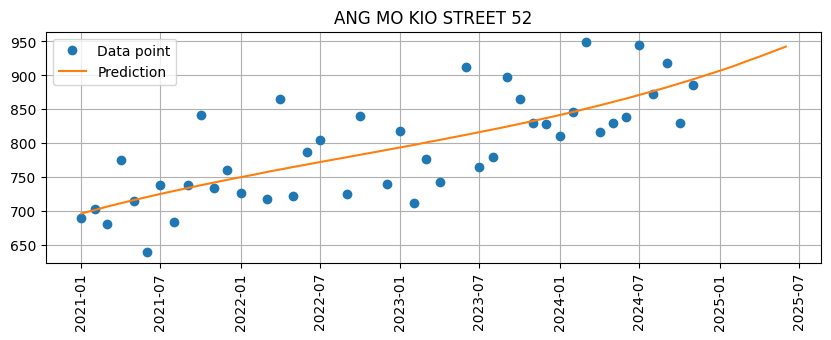

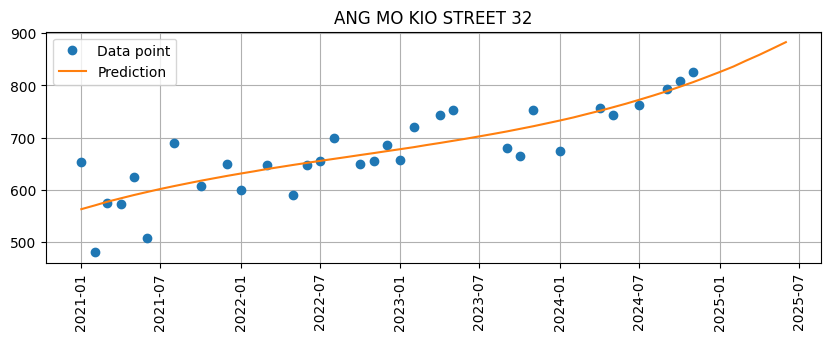

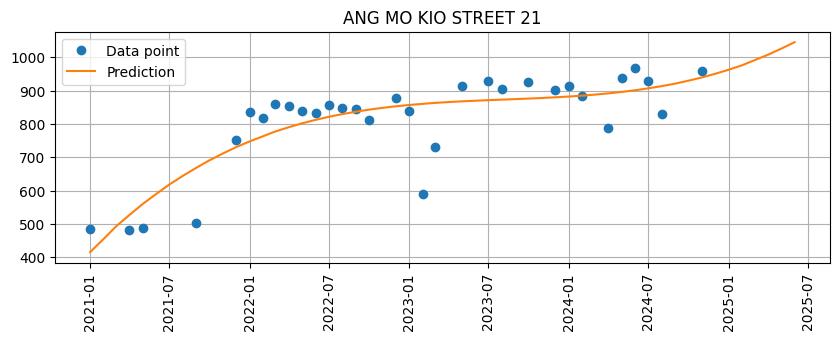

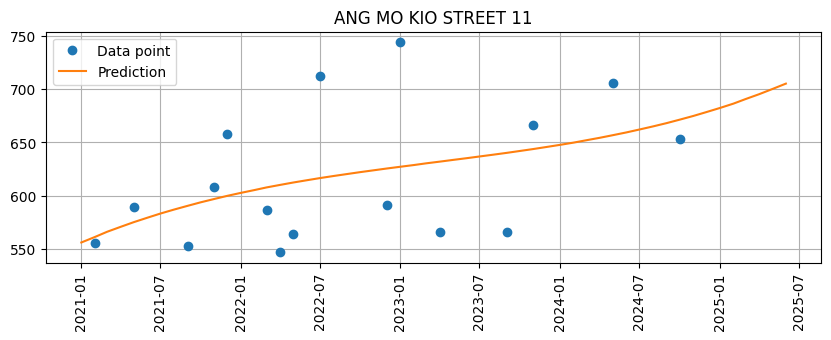

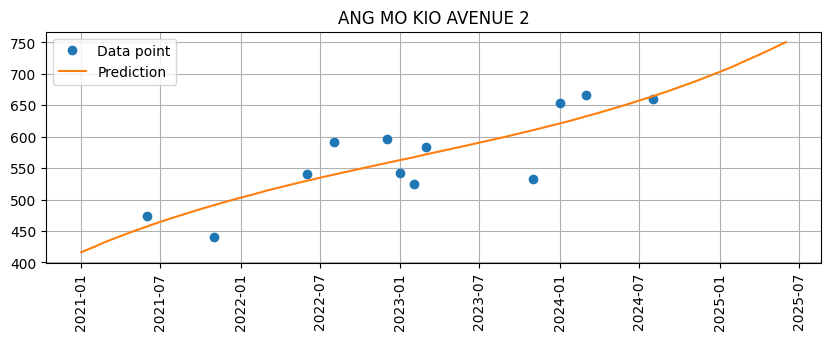

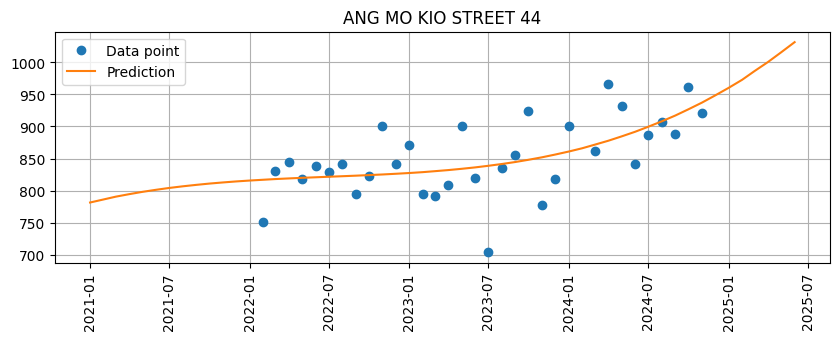

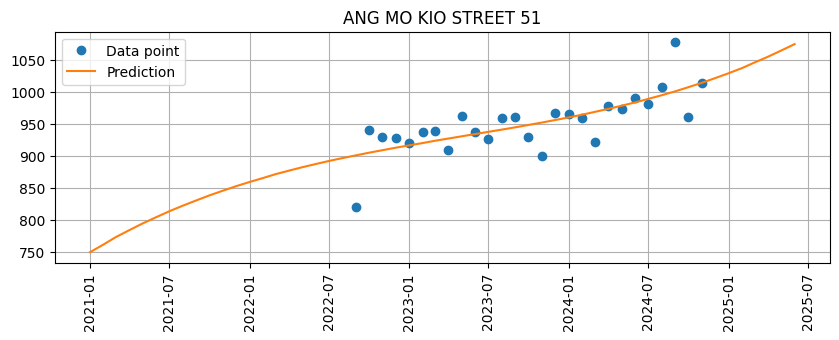

In [44]:
for k in dfs.keys():
    plt.figure(figsize = [10, 3])
    plt.plot(dfs[k][combined], dfs[k]["price_per_sqft"], "o")
    plt.plot(X_pred_months, y_preds[k])
    plt.xticks(rotation = 90)
    plt.legend(["Data point", "Prediction"])
    plt.grid(True)
    plt.title(k)
    plt.show()

In [6]:
"""
y = xdf["price_per_sqft"].values
X = xdf["X"].values

X_pred_months = datetime_df[combined].values
X_pred = datetime_df["X"].values

X_pred_months = np.hstack([X_pred_months, np.datetime64(datetime.datetime(2025, 1, 1))])
X_pred = np.hstack([X_pred, X_pred[-1] + (X_pred[-1] - X_pred[-2])])

kernel = RBF(12, length_scale_bounds = "fixed")
gpr = GaussianProcessRegressor(kernel = kernel)
gpr.fit(X.reshape(-1, 1), y)
y_pred = gpr.predict(X_pred.reshape(-1, 1))

plt.figure(figsize = [15, 5])
plt.plot(xdf[combined], xdf["price_per_sqft"], "o")
plt.plot(X_pred_months, y_pred)
plt.xticks(rotation = 90)
plt.legend(["Data point", "Prediction"])
plt.grid(True)
plt.show()
""";

In [7]:
"""
fig, ax = plt.subplots(figsize = [12, 12])
divider = make_axes_locatable(ax)
cax = divider.append_axes(**{"position": "right", "size": "5%", "pad": 0.1})

#ax.set_xlim([103.60152080468028, 104.0470051248534])
#ax.set_ylim([1.2359029533199608, 1.4733321131970046])
ax.set_title("{} {}.".format("year_month", price_column))

resale_flat_data.df.plot(
    ax = ax,
    alpha = 1.0,
    column = price_column, 
    categorical = False,
    legend = True, 
    legend_kwds = {"label": "price_per_sqft"},
    cmap = 'viridis',
    edgecolor = None,
    cax = cax,
)

cx.add_basemap(ax, crs = resale_flat_data.df.crs, source = cx.providers.CartoDB.Positron)
fig.tight_layout()
plt.show()
""";